In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
# load data
data = pd.read_excel('MMM_Blender_data_2.xlsx')

In [3]:
# Remove ($) in column names
data.columns = data.columns.str.replace(' \(\$\)', '', regex=True)

In [4]:
# Display the structure of the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        150 non-null    object 
 1   Sales       150 non-null    int64  
 2   TV_ads      150 non-null    float64
 3   online_ads  150 non-null    float64
 4   Print_ads   150 non-null    float64
 5   Price       150 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None


In [5]:
# convert the Date Column from object to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%b-%Y')

In [6]:
### Data Cleaning

from scipy.stats import zscore
def remove_outliers_zscore(df, numerical_cols, threshold=3):
    df_cleaned = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    for col in numerical_cols:
        # Calculate Z-scores for the column
        df_cleaned[col + '_zscore'] = zscore(df_cleaned[col])
    
    # Filter out rows where any Z-score is above the threshold
    df_cleaned = df_cleaned[(df_cleaned[[col + '_zscore' for col in numerical_cols]].abs() <= threshold).all(axis=1)]
    
    # Drop Z-score columns
    df_cleaned = df_cleaned.drop(columns=[col + '_zscore' for col in numerical_cols])
    
    return df_cleaned

# Identify numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Remove outliers using Z-score
data= remove_outliers_zscore(data, numerical_cols, threshold=3)

In [7]:
data.head(10)

,Date,Sales,TV_ads,online_ads,Print_ads,Price
0,2008-01-01,6237000,181222.548442,12152.540107,24986.912760,135.0
1,2008-02-01,6115500,179104.353164,57353.376363,17574.385360,135.0
2,2008-03-01,10577250,222756.223235,146794.245435,16016.022899,135.0
3,2008-04-01,13473000,188266.818315,376459.468169,29689.694160,135.0
4,2008-05-01,6258525,210038.289741,21297.573231,17606.991440,136.5
5,2008-06-01,7371000,196292.677236,80514.079702,20905.296790,136.5
6,2008-07-01,8060325,183358.262369,120537.488441,20116.497418,136.5
7,2008-08-01,10278450,192723.580333,218782.364044,17642.672293,136.5
8,2008-09-01,10991700,200450.916640,248129.090562,18509.452326,138.0
9,2008-10-01,9618600,182675.622775,201009.441600,23807.248992,138.0


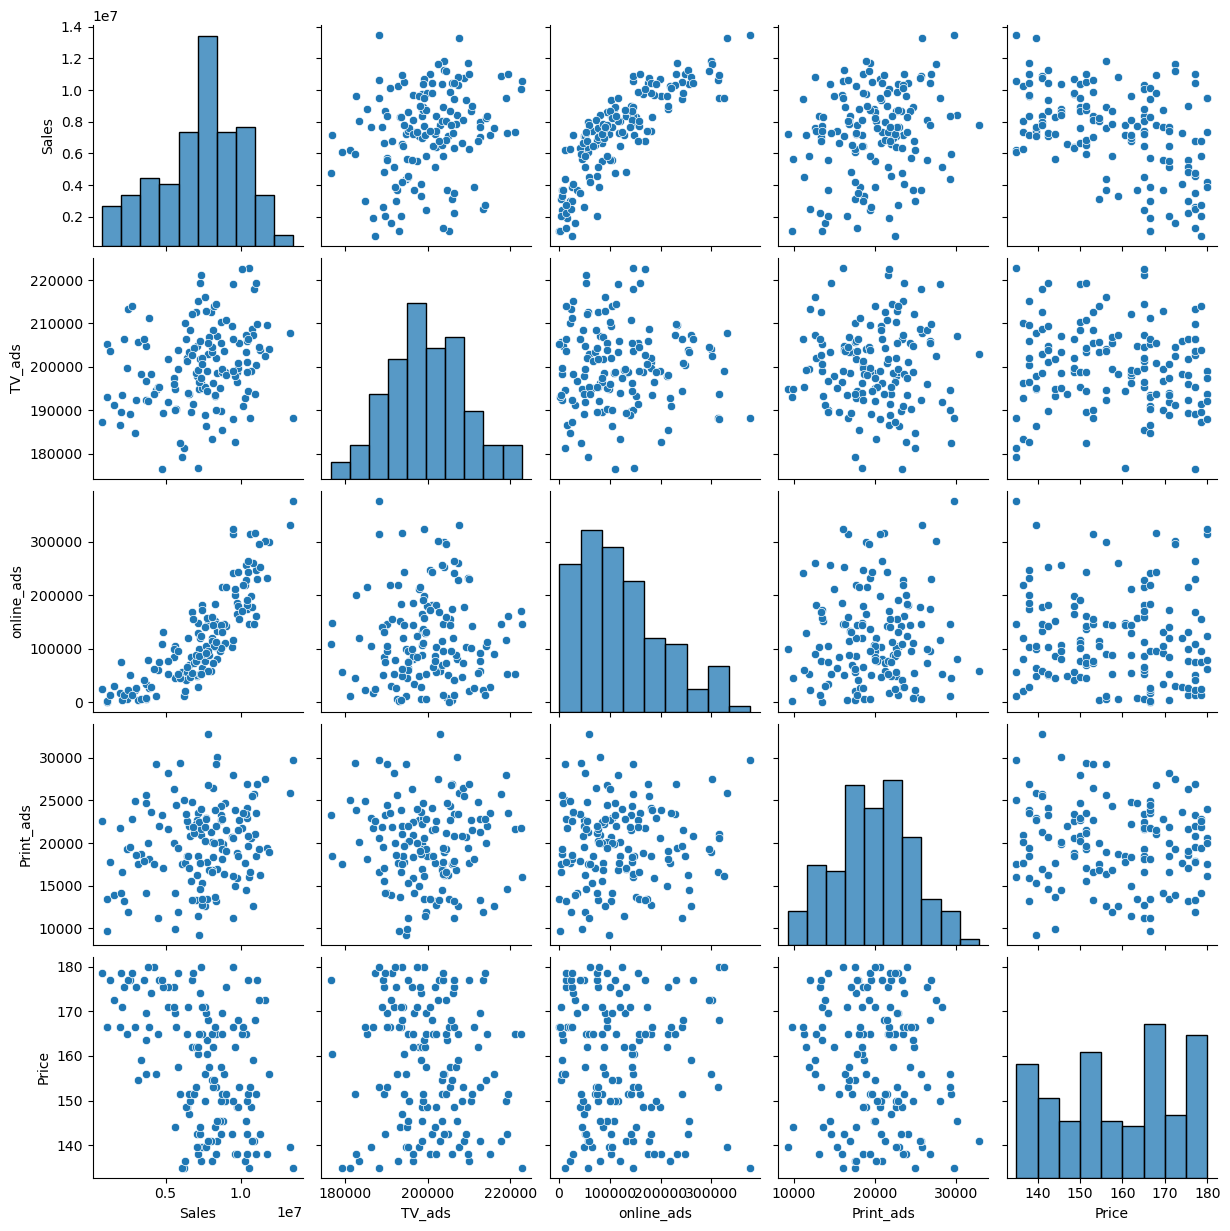

In [8]:
# Pair plot to check for bivariate correlations
sns.pairplot(data)
plt.show()

In [9]:
# Fix skewed online ads by taking the log
data['log_online_ads'] = np.log(data['online_ads'])

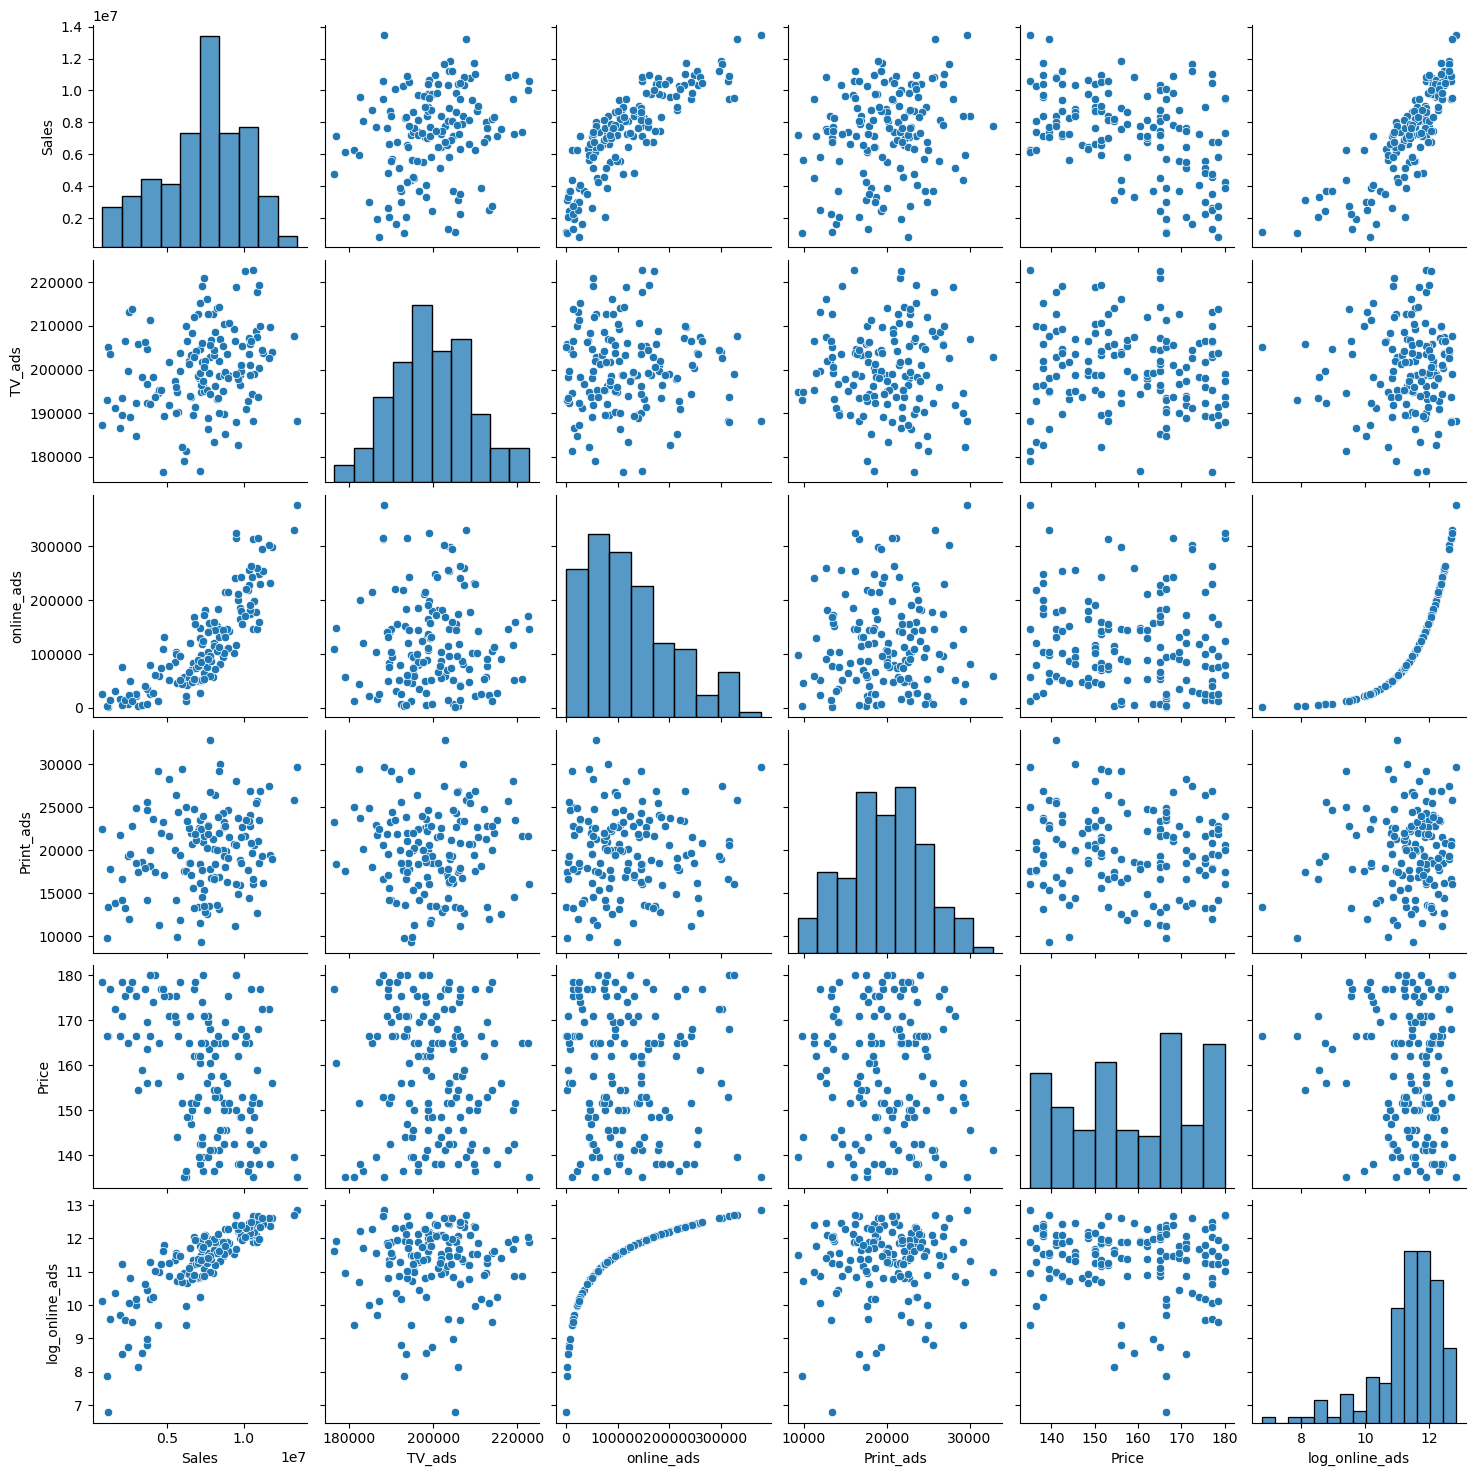

In [10]:
# Replot the pair plot after transformation
sns.pairplot(data)
plt.show()

In [11]:
# It doesn't really fix it so we try sqrt
data['sqrt_online_ads'] = np.sqrt(data['online_ads'])

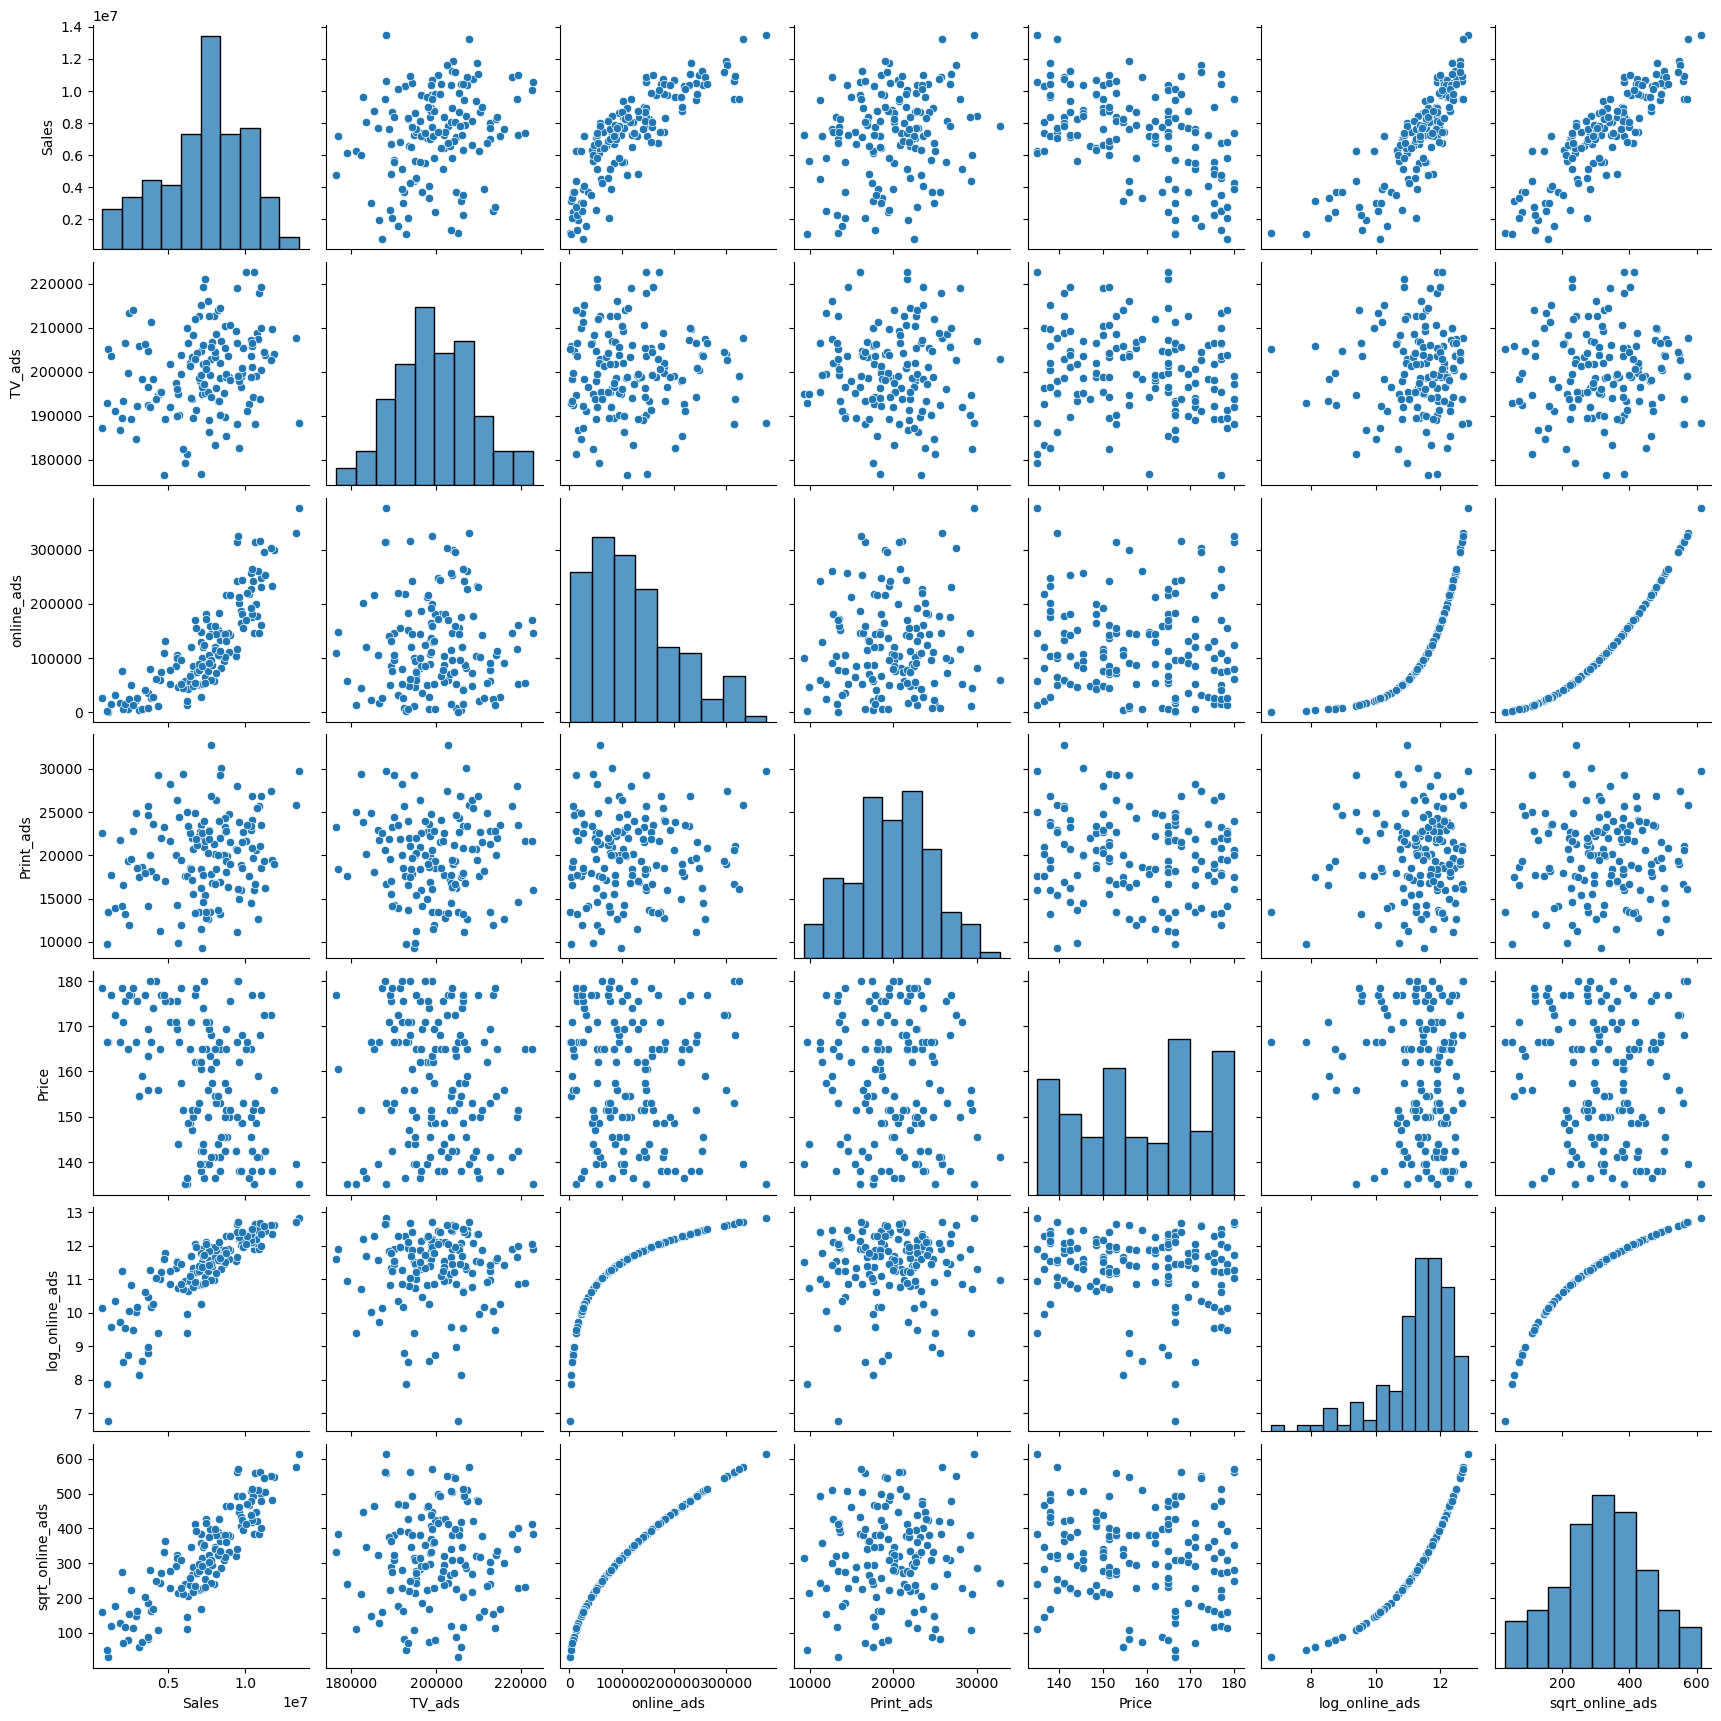

In [12]:
# Replot the pair plot after transformation
sns.pairplot(data)
plt.show()

In [13]:
## it works, so we drop log transform
data = data.drop(columns=["log_online_ads"])

In [14]:
# # Creating trend variables
data['Time_Index'] = range(1, len(data) + 1)
data['Trend_Linear'] = data['Time_Index']
data['Trend_Quadratic'] = data['Time_Index'] ** 2

In [15]:
# # Creating lagged variables for marketing activities
lag_features = ['TV_ads', 'sqrt_online_ads', 'Print_ads', 'Price']
for feature in lag_features:
    data[f'{feature}_lag_1'] = data[feature].shift(1)

In [16]:
## Create Advertisement Pairwise Intersection to observe more insight
adv_channels = ['TV_ads', 'Print_ads', 'online_ads']

## I did square root because of skewness discovered
for i in range(len(adv_channels)):
    for j in range(i + 1, len(adv_channels)):
        col1 = adv_channels[i]
        col2 = adv_channels[j]
        new_col_name = f'{col1}_x_{col2}'
        data[new_col_name] = np.sqrt(data[col1] * data[col2])
    

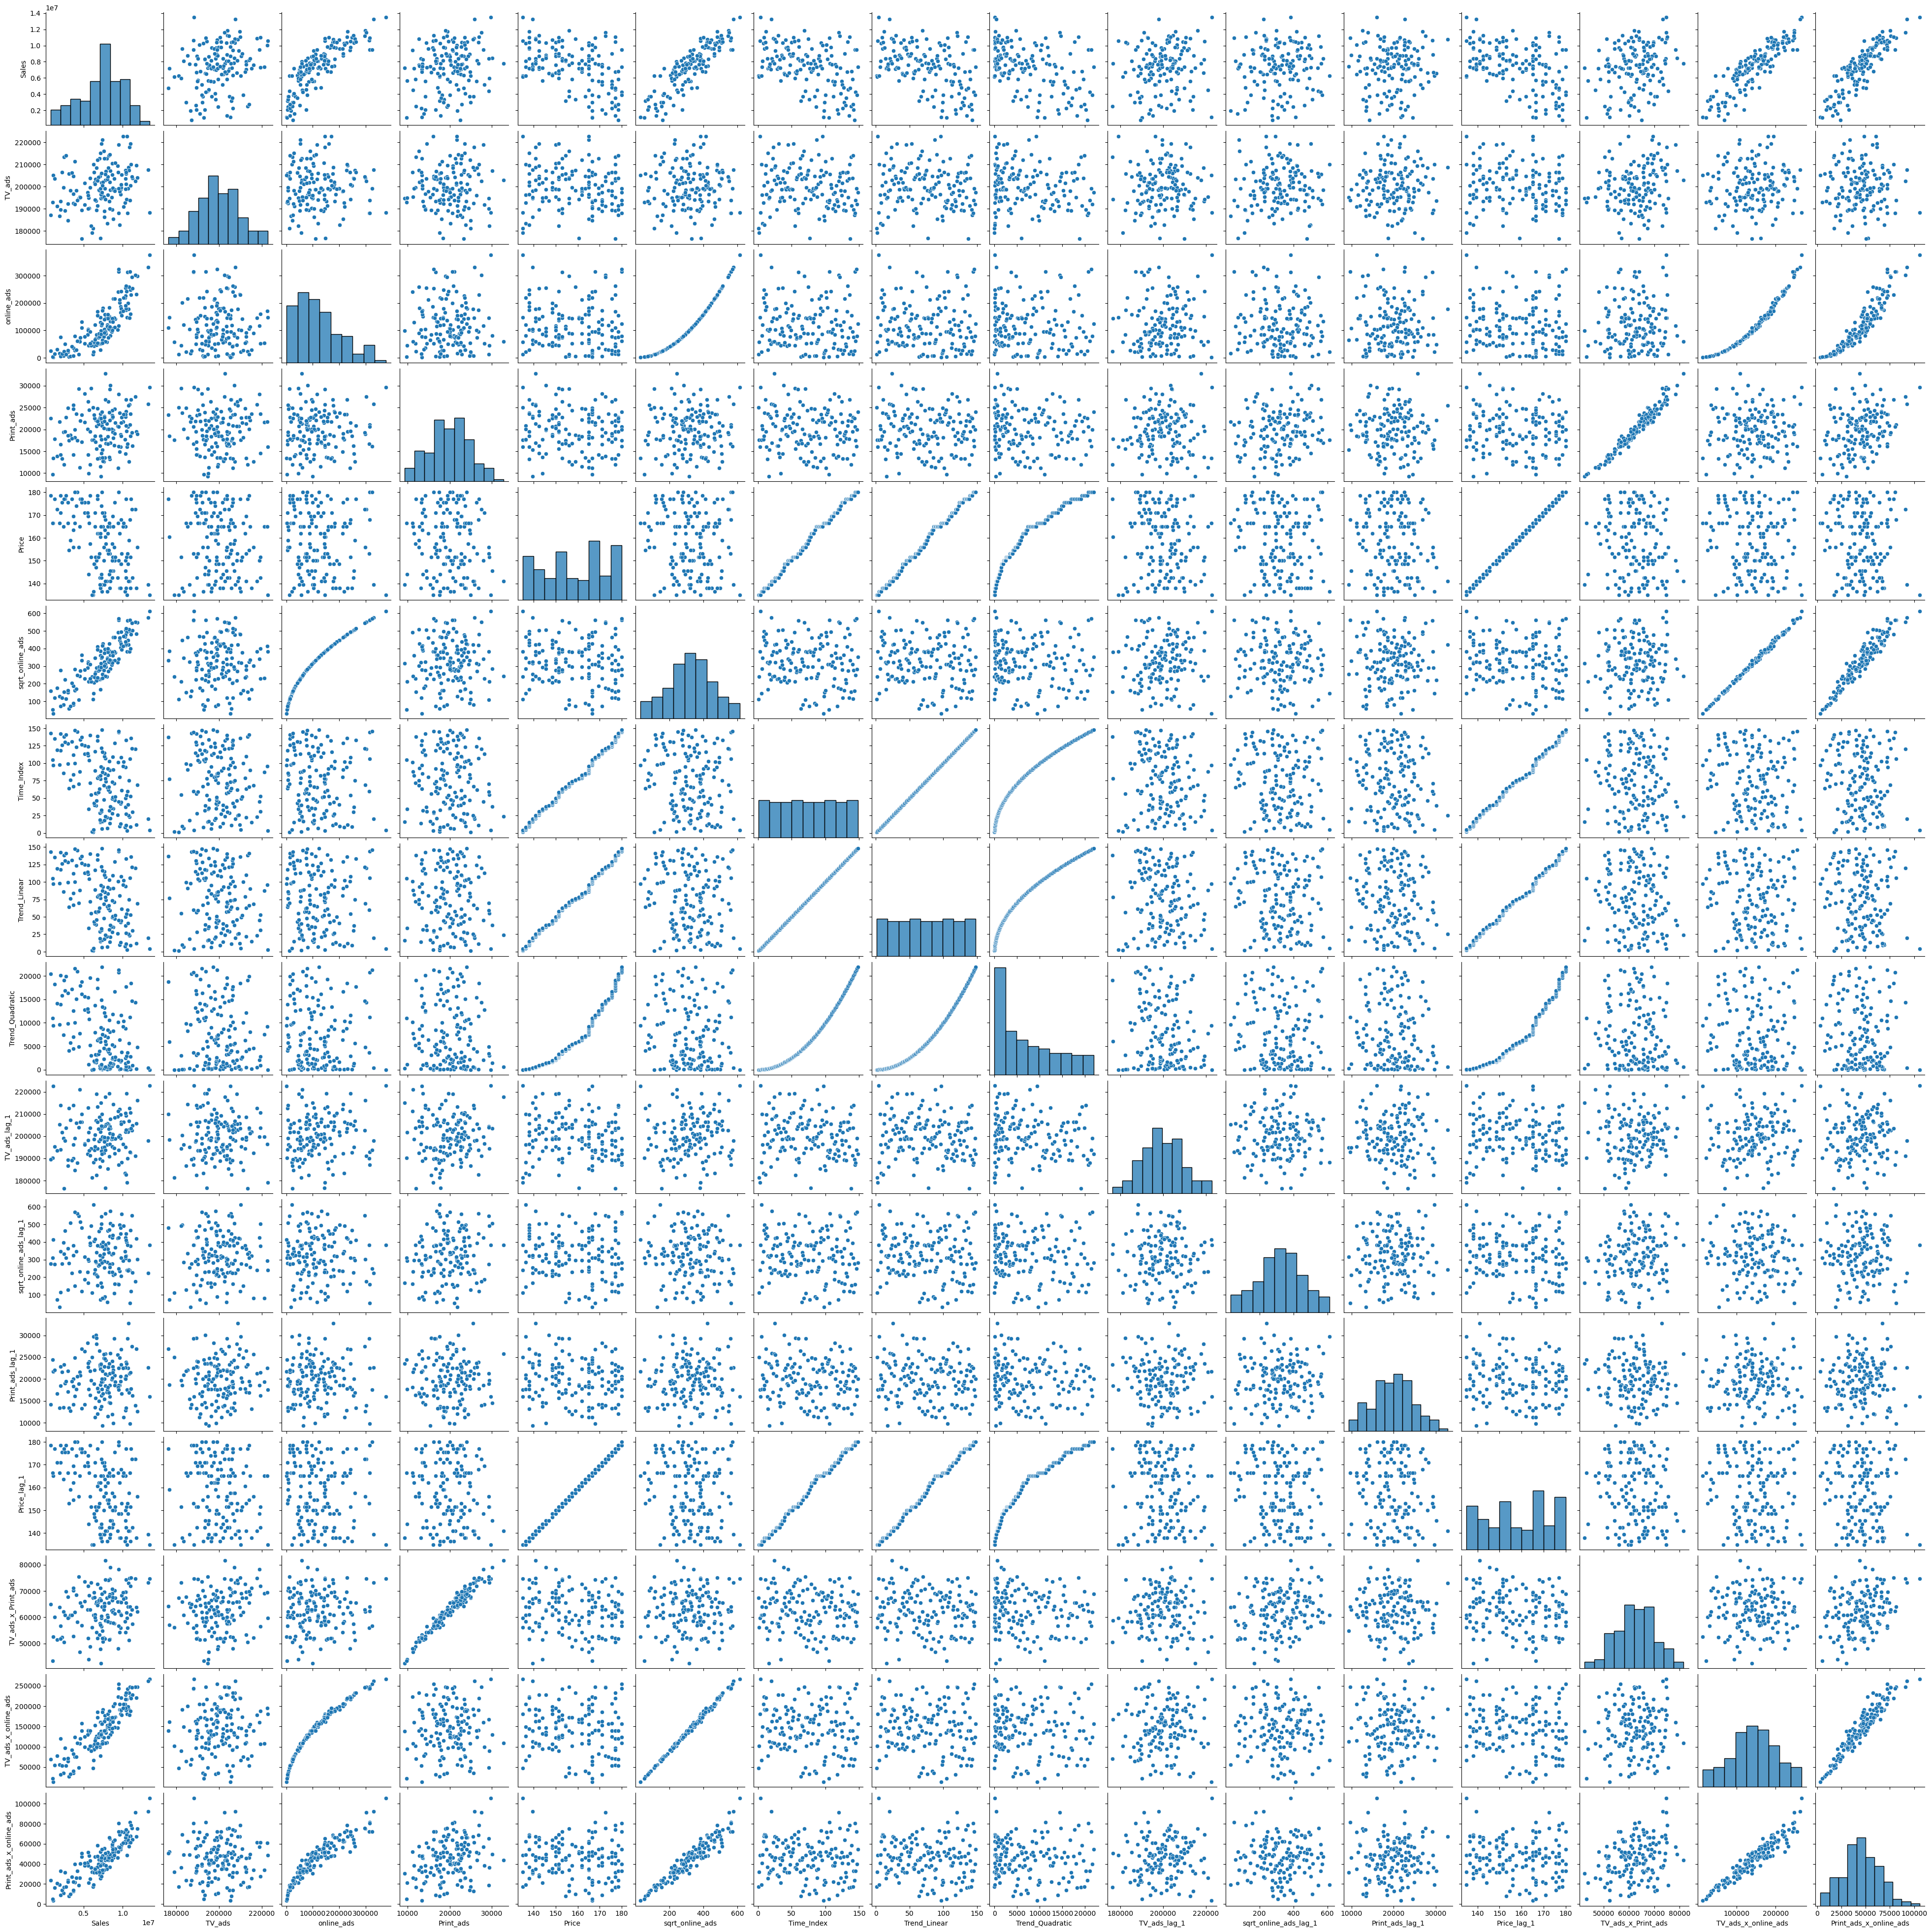

In [17]:
# Replot the pair plot after transformation
sns.pairplot(data)
plt.show()

<Axes: >

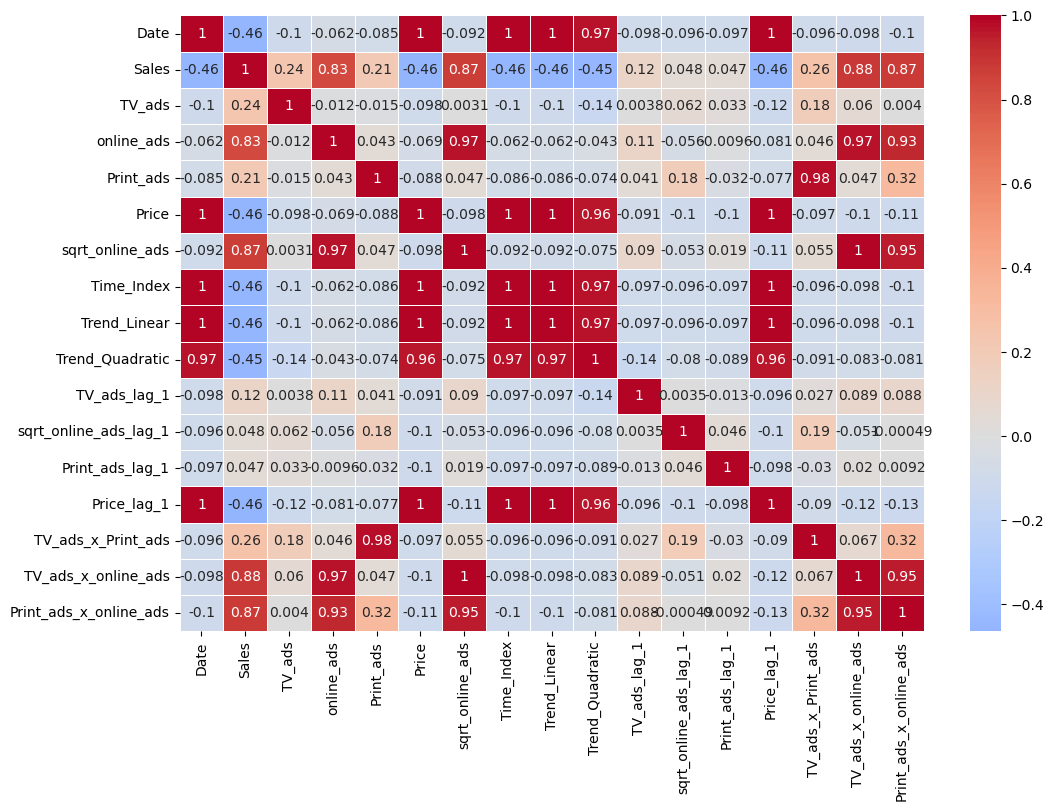

In [18]:
# # Correlation matrix and plot using seaborn's heatmap
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))  # Adjust the size to fit your data
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)

In [19]:
## drop colums that might cause multi colinearity
data = data.drop(columns=["online_ads", "Time_Index","Trend_Linear","Date","TV_ads_x_Print_ads","TV_ads_x_online_ads","Print_ads_x_online_ads"])

<Axes: >

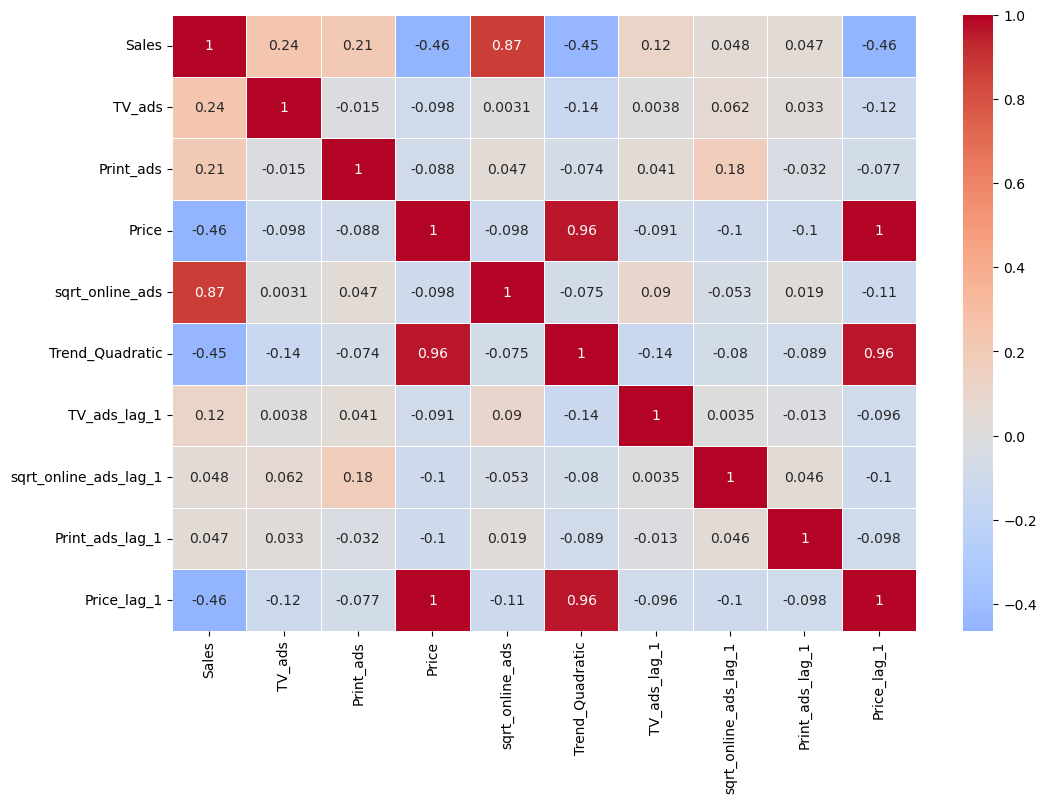

In [20]:
# # Correlation matrix and plot using seaborn's heatmap
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))  # Adjust the size to fit your data
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)

In [21]:
## drop N/A
data = data.dropna()

In [22]:
# Fitting a model
m1 = smf.ols('Sales ~ TV_ads + Print_ads + sqrt_online_ads + Trend_Quadratic + np.sqrt(TV_ads * sqrt_online_ads) + np.sqrt(Print_ads * sqrt_online_ads) + Price + Price_lag_1 + Print_ads_lag_1 + sqrt_online_ads_lag_1', data=data).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     404.0
Date:                Thu, 29 Aug 2024   Prob (F-statistic):           6.68e-96
Time:                        16:24:56   Log-Likelihood:                -2136.7
No. Observations:                 147   AIC:                             4295.
Df Residuals:                     136   BIC:                             4328.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [23]:
print("\nCoefficients:")
print(m1.params)


Coefficients:
Intercept                              -9.488921e+06
TV_ads                                  6.241147e+01
Print_ads                               3.404565e+01
sqrt_online_ads                         1.693553e+04
Trend_Quadratic                        -1.219256e+02
np.sqrt(TV_ads * sqrt_online_ads)      -1.526730e+02
np.sqrt(Print_ads * sqrt_online_ads)    7.493052e+02
Price                                  -2.189118e+04
Price_lag_1                             1.124752e+04
Print_ads_lag_1                        -3.045150e+00
sqrt_online_ads_lag_1                   5.687323e+02
dtype: float64


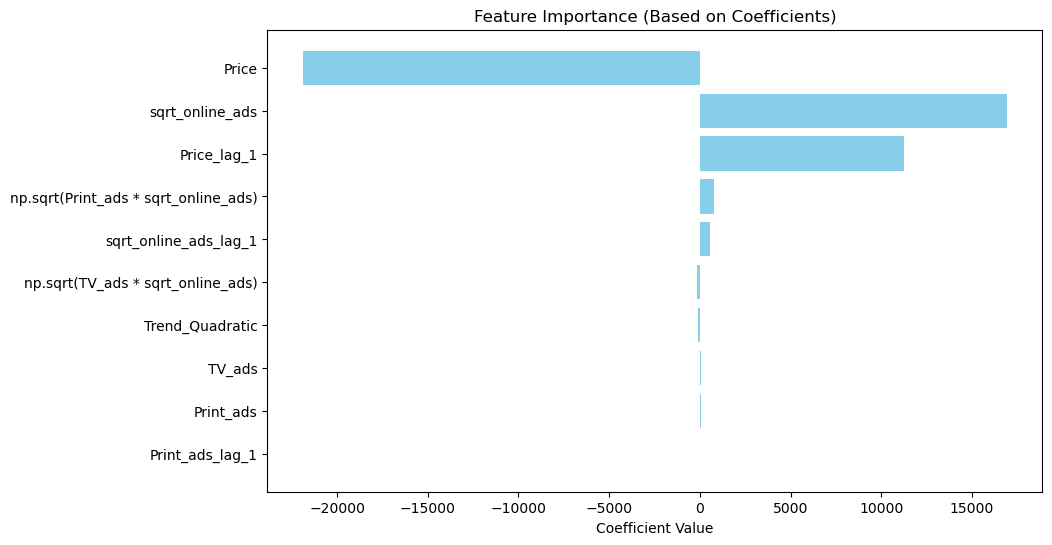

In [24]:
## Feature Importance

# Extract the coefficients from the fitted model and exclude the intercept
coefficients = m1.params.drop('Intercept')

# Convert coefficients to a DataFrame for easier plotting
coefficients_df = coefficients.reset_index()
coefficients_df.columns = ['Feature', 'Coefficient']

# Sort by absolute value of the coefficients to see the most important features first
coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Based on Coefficients)')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()



In [25]:
# # Feature Engineering: Time-based features
# # Extracting seasonal features
# data['Month'] = data['Date'].dt.month
# data['Week_of_Year'] = data['Date'].dt.isocalendar().week
# data['Day_of_Week'] = data['Date'].dt.dayofweek

# # Creating trend variables
# data['Time_Index'] = range(1, len(data) + 1)
# data['Trend_Linear'] = data['Time_Index']
# data['Trend_Quadratic'] = data['Time_Index'] ** 2

# # Creating lagged variables for marketing activities
# lag_features = ['TV_ads', 'sqrt_online_ads', 'Print_ads']
# for feature in lag_features:
#     data[f'{feature}_lag_1'] = data[feature].shift(1)
#     data[f'{feature}_lag_2'] = data[feature].shift(2)
#     data[f'{feature}_lag_3'] = data[feature].shift(3)

# # Calculating rolling means
# for feature in lag_features:
#     data[f'{feature}_rolling_mean_3'] = data[feature].rolling(window=3).mean()
#     data[f'{feature}_rolling_mean_6'] = data[feature].rolling(window=6).mean()

# # Drop the initial rows with NaN values caused by lagging
# data = data.dropna().reset_index(drop=True)

In [26]:
# # Correlation matrix and plot using seaborn's heatmap
# plt.figure(figsize=(12, 8))  # Adjust the size to fit your data
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)

In [27]:
# Test with Linear Regression

In [28]:
## DROP least important, I primarily choose to drop the one that is created during feature eng, but not the original data
X1 = data.drop(columns=['Sales','Print_ads_lag_1','sqrt_online_ads_lag_1']).values
y1 = data['Sales'].values

In [30]:
## Coefficient here: 
print("\nCoefficients:")
print(m1.params)


Coefficients:
Intercept                              -9.250438e+06
TV_ads                                  6.319983e+01
Print_ads                               3.676257e+01
sqrt_online_ads                         1.712240e+04
Trend_Quadratic                        -1.191476e+02
np.sqrt(TV_ads * sqrt_online_ads)      -1.710448e+02
np.sqrt(Print_ads * sqrt_online_ads)    7.520752e+02
Price                                  -2.494702e+04
Price_lag_1                             1.259317e+04
dtype: float64


In [31]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1,y1,train_size=0.8,random_state=42)

In [32]:
# Train our model and assess it against training data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Machine Learning Model: Linear Regression
lr = LinearRegression().fit(X1_train, y1_train)
# Machine Learning Model: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X1_train, y1_train)

In [33]:
# Performance of Linear Regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy import sqrt

print("R^2:",lr.score(X1_train,y1_train))
print("Root Mean Squared Error:",sqrt(
    mean_squared_error(y1_train,lr.predict(X1_train))))
print("Mean Absolute Error:",mean_absolute_error(
    y1_train,lr.predict(X1_train)))

R^2: 0.9653117360759087
Root Mean Squared Error: 502179.03690717876
Mean Absolute Error: 397298.74591191305


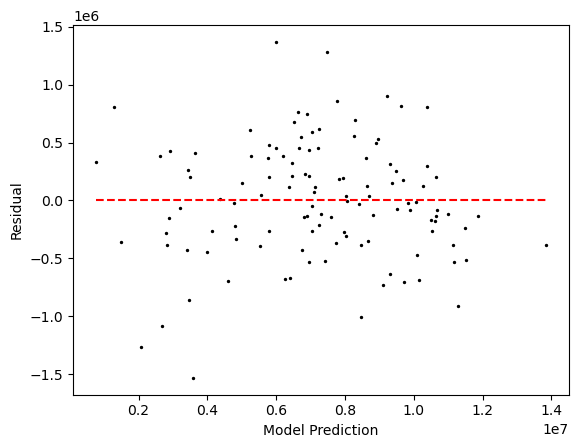

In [34]:
#Residuals calculated by definition above.
predicted_y1 = lr.predict(X1_train)
#Note we can perform element-wise subtraction between arrays like so
residuals1 = y1_train - predicted_y1

import matplotlib.pyplot as plt
plt.scatter(predicted_y1,residuals1,s=2,c='black')

#This line adds the dashed horizontal line
plt.hlines(0,min(predicted_y1),max(predicted_y1),color='red',linestyles='dashed')

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

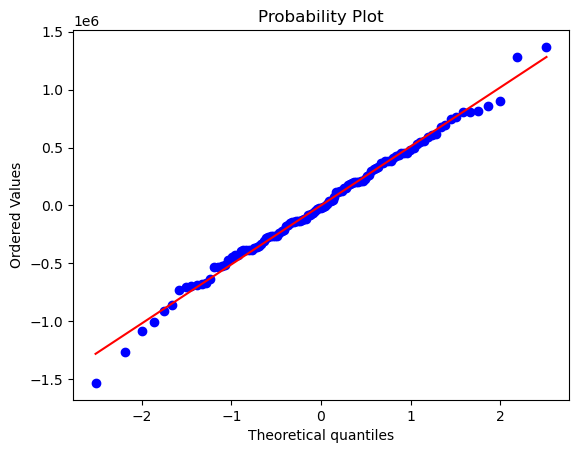

In [35]:
import scipy.stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)

stats.probplot(residuals1,dist='norm',plot=ax)
plt.show()

In [36]:
# Performance of Random Forest
print("R^2:",rf.score(X1_train,y1_train))
print("Root Mean Squared Error:",sqrt(
    mean_squared_error(y1_train,rf.predict(X1_train))))
print("Mean Absolute Error:",mean_absolute_error(
    y1_train,rf.predict(X1_train)))

R^2: 0.9851441014633018
Root Mean Squared Error: 328637.2284471116
Mean Absolute Error: 258831.59615384616


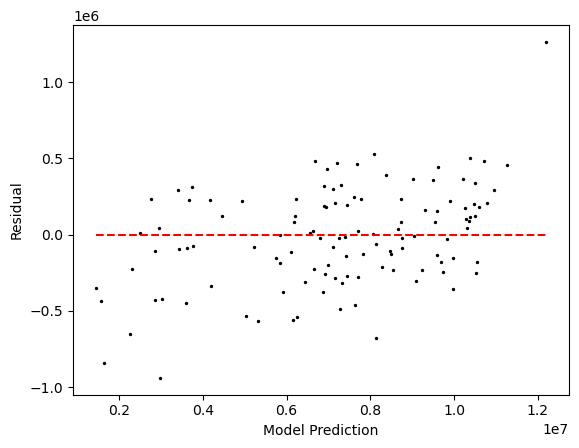

In [37]:
### Evaluation of performance of RF 

#Residuals calculated by definition above.
predicted_y1 = rf.predict(X1_train)
#Note we can perform element-wise subtraction between arrays like so
residuals1 = y1_train - predicted_y1

import matplotlib.pyplot as plt
plt.scatter(predicted_y1,residuals1,s=2,c='black')

#This line adds the dashed horizontal line
plt.hlines(0,min(predicted_y1),max(predicted_y1),color='red',linestyles='dashed')

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

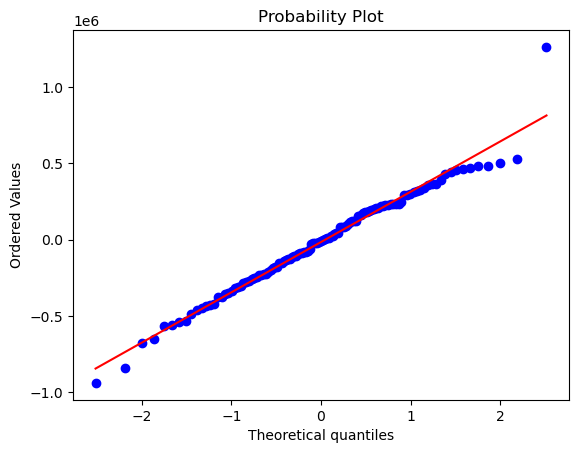

In [38]:
import scipy.stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)

stats.probplot(residuals1,dist='norm',plot=ax)
plt.show()

In [39]:
# Calculate the elasticity for each variable in the linear model

coefficients = m1.params
mean_values = X1_train.mean()

# Elasticity = coefficient * (mean value of X / mean value of Y)
elasticities = coefficients * (mean_values / y1_train.mean())

elasticities = elasticities.round(3)

# Display the elasticities
print(elasticities)


Intercept                              -78248.622
TV_ads                                      0.535
Print_ads                                   0.311
sqrt_online_ads                           144.837
Trend_Quadratic                            -1.008
np.sqrt(TV_ads * sqrt_online_ads)          -1.447
np.sqrt(Print_ads * sqrt_online_ads)        6.362
Price                                    -211.025
Price_lag_1                               106.525
dtype: float64


Choose Linear Regression, since better story telling, etc.. 

In [41]:
# Calculate the contribution to the outcome for each variable
contributions = coefficients * mean_values

# Calculate the ROI for each variable
roi = contributions / mean_values

# Display the ROI
roi = roi.round(3)
print(roi)

Intercept                              -9250437.738
TV_ads                                       63.200
Print_ads                                    36.763
sqrt_online_ads                           17122.404
Trend_Quadratic                            -119.148
np.sqrt(TV_ads * sqrt_online_ads)          -171.045
np.sqrt(Print_ads * sqrt_online_ads)        752.075
Price                                    -24947.022
Price_lag_1                               12593.171
dtype: float64


In [40]:
#feature_importances = rf.feature_importances_
#feature_importances

Interpretation: (THIS IS FROM GPT, REMEMBER TO EXPALIN BY URSELF!!!!)
Price Elasticity (-185.18):

For every 1% increase in price, sales decrease by approximately 185.18%. This indicates that sales are highly sensitive to price changes, with higher prices leading to a substantial drop in sales. This strong negative elasticity suggests that careful attention should be paid to pricing strategies, as even small price increases can lead to significant reductions in sales volume.
Online Ads Elasticity (143.26):

For every 1% increase in the square root of online ads spend, sales increase by approximately 143.26%. This indicates that online advertising has a significant positive impact on sales, with increased spending leading to substantial growth in sales. The high elasticity suggests that online ads are a very effective channel for driving sales, making it a critical area for investment.
TV Ads Elasticity (0.53):

For every 1% increase in TV ads spend, sales increase by approximately 0.53%. This suggests that while TV advertising does have a positive impact on sales, the effect is relatively small compared to other channels. This might indicate that TV ads are less effective in driving sales or that their impact is more incremental rather than dramatic.
Print Ads Elasticity (0.29):

For every 1% increase in print ads spend, sales increase by approximately 0.29%. Similar to TV ads, this indicates a positive but modest effect of print advertising on sales. This suggests that print ads may not be as strong a driver of sales compared to other forms of advertising, such as online ads.
Trend Quadratic Elasticity (-1.03):

For every 1% increase in the quadratic trend variable, sales decrease by approximately 1.03%. This negative elasticity suggests that sales are trending downward over time, possibly due to market saturation, changing consumer preferences, or other external factors. The quadratic nature indicates that the rate of decline might be accelerating.
Interaction: TV Ads and Online Ads Elasticity (-1.29):

For every 1% increase in the interaction between TV ads and the square root of online ads, sales decrease by approximately 1.29%. This negative elasticity suggests that when these two channels are combined, their joint effect on sales is slightly detrimental. This might indicate diminishing returns when both channels are used together.
Interaction: Print Ads and Online Ads Elasticity (6.34):

For every 1% increase in the interaction between print ads and the square root of online ads, sales increase by approximately 6.34%. This strong positive elasticity suggests that these channels work well together, amplifying each other’s effects and leading to a significant boost in sales.
Lagged Price Elasticity (95.14):

For every 1% increase in the lagged price, sales increase by approximately 95.14%. This positive elasticity might seem counterintuitive, but it could indicate that previous price increases have a delayed effect on sales, possibly due to factors like consumer perception of value or delayed purchasing behavior.
Lagged Print Ads Elasticity (-0.03):

For every 1% increase in the lagged print ads spend, sales decrease by approximately 0.03%. This small negative elasticity suggests that past spending on print ads might have a slight adverse effect on current sales, possibly due to overexposure or diminishing returns.
Lagged Online Ads Elasticity (4.81):

For every 1% increase in the lagged online ads spend, sales increase by approximately 4.81%. This positive elasticity indicates a significant carryover effect from online ads, suggesting that past online advertising efforts continue to drive sales in subsequent periods.
